<a href="https://colab.research.google.com/github/nenadgolubovic/AI_Agent_Technical_Documentation_Analyzer/blob/main/AI_Agent_Technical_Documentation_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Agent Avio Technical Documents Analyzer**

This Colab notebook presents the development of an AI agent designed to assist engineers in reviewing technical documentation. The work introduces an agent based on LangGraph, which allows users to interact with it and ask questions. The system also provides the functionality to upload documents directly through the prompt, enabling the agent to automatically analyze the content and store it in a vector database for efficient retrieval and querying.

Neccessery library

In [1]:
!pip install langchain langchain-community pypdf
!pip install langchain-community
!pip install -U langgraph langsmith
!pip install langchain-chroma
!pip install langgraph
!pip install camelot
!pip -q install langchain_groq
!pip install typing-extensions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.2/373.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.13
    Uninstalling langsmith-0.4.13:
      Successfully uninstalled langsmith-0.4.13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install langchain langsmith --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 0.7.10
    Uninstalling SQLAlchemy-0.7.10:
      Successfully uninstalled SQLAlchemy-0.7.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
camelot 12.6.29 requires SQLAlchemy<0.8.0,>=0.7.7, but you have sqlalchemy 2.0.43 which is incompatible.


This section presents the auxiliary functions that will be required throughout the work. These functions support the main operations of the AI agent and facilitate tasks such as document processing, data handling, and interaction with the vector database.

In [3]:
import textwrap

def wrap_text_preserve_newlines(text, width = 110):

  lines = text.split("\n")

  wrapped_lines = [textwrap.fill(line, width = width) for line in lines]

  wrapped_text = "\n".join(wrapped_lines)

  return wrapped_text

def print_retrieced_doc(result):
  print(f"CONTENT:\n{wrap_text_preserve_newlines(result.page_content)}")
  print(f"\nSOURCE: {result.metadata['source']}, page: {result.metadata['page']}")

Connection on langsmith.

In [ ]:
import os
from google.colab import userdata
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "AI_Agent_Avio_Technical_Documents_Analyzer"

A State class is defined, inheriting from LangGraph's MessagesState class, enabling the agent to have insight into the current state of the graph. This allows the agent to manage and respond based on the context of the ongoing interactions.

In [5]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from typing_extensions import Annotated

class MsgState(MessagesState):
  response_src: str
  query_type:str
  path_of_file:str
  documents: list
  splitter_result: str
  vdb_filled_with_docs: bool
  classification_list: str


# Instantiation of the LLM Model

In [15]:
import os
from google.colab import userdata
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

llm = ChatGroq(
    model = "llama-3.1-8b-instant",
    temperature = 0.1
)

#Type of communication with llama-3.1
def get_promt(user_massage, system_massage):
  promt_txt  = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
  promt_txt += system_massage
  promt_txt += "<|eot_id|>\n<|start_header_id|>uset<|end_header_id|>\n\n"
  promt_txt += f"{user_massage}<|eot_id|>\n"
  promt_txt += "<|start_header_id|>assistant<|end_header_id|>"
  return promt_txt

# Instantiation of the Vector Database

In [16]:
from langchain_chroma import Chroma
from langchain.schema import Document


def filling_db_with_documents(documents_list):
  persist_directory = 'tech_doc_on_db'
  documents = [Document(page_content=d) for d in documents_list]
  vectordb = Chroma.from_documents(documents = documents,
                                  embedding = embadings,
                                  persist_directory = 'tech_doc_on_db')

  # Test of searching documents in database
  results = vectordb.similarity_search("test", k=3) #find 3 documents which is similart to string "test"
  if results:
      print("\n First Document (Full document model):\n")
      print(results)
      print("\n" + "="*80 + "\n")  # separator for readable text
  else:
      print("No Results in database!")

#Instation of Tools

For now, the only tool we have is one for retrieving data from the vector database.
In future work, we could add a web search function or a function to generate structured JSON from tabular documents. However, for simplicity and to reduce the complexity of the graph, I decided not to implement these features.


In [17]:
from langchain import PromptTemplate
import json
from langchain_core.tools import tool
from pydantic import BaseModel
from langchain.tools import tool


@tool()
def retriever(query:str):
  " Retreivers information from a repository of technical documentation.This tool is used to search for specific data related to: Engine Serial Number (ESN), Time Since New (TSN), Cycle Since New (CSN), General technical documents for aircraft engines. It is activated for any query related to these topics."

  print("-----ACTIVATED RETRIEVER----") # debug function to show does activated tool function
  vectordb = Chroma(
        persist_directory='tech_doc_on_db',
        embedding_function=embadings
    )
  db_search = vectordb.as_retriever(search_type = "mmr", search_kwargs = {"k":3})

  retreived_docs = db_search.invoke(query)

  retrieved_str = "\n\n".join([doc.page_content for doc in retreived_docs])

  return retrieved_str

# Definition of embadding model

In [18]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import warnings
model_name = "BAAI/bge-large-en-v1.5"

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  embadings = HuggingFaceBgeEmbeddings(
      model_name = model_name,
      model_kwargs = {"device":"cuda"},
      encode_kwargs = {"normalize_embeddings": True}
  )

# Definition of node functions

In [19]:
from langgraph.prebuilt import ToolNode
tools = ToolNode([retriever])

In [20]:
from langchain.schema import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
import json
import re


def should_collect_more_info(state: MsgState):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        print(f"Function should_collect_more_info returns: Tools") #debuger
        return "Tools"

    print(f"Function should_collect_more_info returns: Present Response") # debuger
    return "Present Response"

def present_response(state:MsgState):

  last_msg = state['messages'][-1]
  if last_msg.type.lower() == 'ai' and last_msg.content != "":
    print(f"RESPONSE:\n{wrap_text_preserve_newlines(last_msg.content)}")
  user_prompt = '\n\nPlease let me know if you have any futher questions\n'
  user_input = input(user_prompt)

  return {'messages':[HumanMessage(content=user_input)]}



def generate_response(state:MsgState):
  print("--- Activated 'Generate Response' node ---") #debug
  recent_tool_messages = []

  for message in reversed(state["messages"]):
    if message.type == "tool":
      recent_tool_messages.append(message)
    else: break
  recent_tool_messages.reverse()
  retreived_content = "\n\n".join(msg.content for msg in recent_tool_messages)
  system_promt_message = """You are the agent in charge of the question-and-answer task.
                            Use specific parts to form an answer, be concise in no more
                            than 3 to 4 sentences, if you don't know, say I don't know, or
                            if question is related to techincal documents write 'I don't know, plase upload document'"""



  system_promt_message += f"\n\nCONTENT:\n\n {retreived_content}"

  user_query = None
  for message in reversed(state["messages"]):
    if message.type == "human":
      user_query = message
      break

  prompt = [SystemMessage(system_promt_message),
            user_query]
  response = llm.invoke(prompt)
  return {"messages":[response]}


def invoke_model(state:MsgState):
  print("--- Activated 'Invoke Model' node ---")
  llm_with_tools = llm.bind_tools([retriever])
  llm_response = llm_with_tools.invoke(state["messages"])
  return {"messages":[llm_response]}


# This function represents the “brain” for message reasoning. If a question is general, the function will return that it is general.
# If it relates to a document, it will indicate that it concerns a document and provide the path to the document.

def question_reasoning(state: MsgState):
    """
    Uses the LLM to decide whether the query is related to a document or not,
    and if related, whether a document path was passed.
    Please answer with a list ['general'] if it is a general question or with
    ['document','path'] if it is a question related to uploading documents,
    where 'path' should be the actual path.
    """
    print("--- Activated 'Question Reasoning' node ---")

    # Last msg
    user_input = state.get("messages", [""])[-1]
    if isinstance(user_input, dict):
        content = user_input.get("content", "")
    else:
        content = str(user_input)

    template = PromptTemplate.from_template("""
        Based on the user's input: "{content}"

        Your task is to classify the input strictly as either a general question or a document-related request.

        Instructions:
        1.  If the input contains a file path (e.g., 'C:/docs/file.pdf', 'report.docx'), respond with a list of two strings: **["document", "<path>"]**. Replace `<path>` with the actual path.
        2.  If the input does NOT contain a file path, respond with a list of a single string: **["general"]**. This applies even if the question is about documents in general.

        Your response MUST be ONLY one of the following two formats, and nothing else:
        - ["general"]
        - ["document", "path_goes_here"]

        Do NOT provide any explanations, comments, or programming code. Just the list.
    """)

    # Create chain and return string
    chain = template | llm | StrOutputParser()

    # call LLM-a
    decision_raw = chain.invoke({"content": content}).strip()
    print("RAW DECISION FROM LLM:", decision_raw)

    # Parser resukt
    try:
        import ast
        decision_list = ast.literal_eval(decision_raw)

        if decision_list and decision_list[0].lower() == "general":
            state["query_type"] = "general"
            state["path_of_file"] = None
        elif decision_list and decision_list[0].lower() == "document" and len(decision_list) > 1:
            state["query_type"] = "document"
            state["path_of_file"] = decision_list[1]
        else:
            # If not possible to parse put general
            state["query_type"] = "general"
            state["path_of_file"] = None
            print("WARNING: Parsing wrkong, returns general.") #debug

    except (ValueError, SyntaxError) as e:
        print(f"WARNING: Parsing wrkong, {e}") #debug
        state["query_type"] = "general"
        state["path_of_file"] = None

    print("QUERY TYPE:", state["query_type"]) #debug
    print("Data path:", state["path_of_file"]) #debug
    return state

#Uplaoding document function
def upload_documents(state: MsgState):
    print("--- Activated 'Upload Document' node ---")
    file_path = state["path_of_file"]
    print(f"Processing file '{file_path}'") #debug

    loader = PyPDFLoader(file_path)
    documents = loader.load()

    return {
        **state,
        "documents": documents
    }

#Spliting documnent based on llm

def split_documents_per_context(state:MsgState):
  print("--- Activated 'split_documents_per_context' node ---")
  document = state['documents']
  document_text = "\n".join(
    f"[PAGE {doc.metadata['page']}] {doc.page_content}"
    for doc in state['documents'])
  prompt =   """
    You are an expert agent specialized in segmenting large multi-page documents based on their content and logical structure.
    Process the pages sequentially, from the first to the last. Identify boundaries where one logical document ends and another begins.
    Return a list of page ranges that represent each distinct document segment.
    Please provide the output strictly as a list of page ranges (e.g., [1-3], [4-7], [8]) without any additional explanation or text.
  """

  qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt),
        ("human", "QUESTION: Divide the document into pages for me, this is the document {document_text}")
    ]
)

  response_generator = qa_prompt | llm
  response = response_generator.invoke({"document_text":document_text})
  return {
        **state,
        "splitter_result": response.content
    }


# Classify documents regarding LLM, I expect with better LLM classification will be better, but to show how we can use agent I took llama3 llm

def document_classificator(state:MsgState):
  print("--- Activated 'document_classificator' node ---")
  splitter_results =  state["splitter_result"]
  document = state['documents']
  document_text = "\n".join(
    f"[PAGE {doc.metadata['page']}] {doc.page_content}"
    for doc in state['documents'])
  prompt = """
          You are given:
          1. The content of a document, with each page labeled in the format [PAGE X].
          2. A list of page ranges that define how the document is segmented. Each page range is continuous, e.g., [1-3], [4-5], [6].

          Your task:
          For each page range:
          - Combine the text of the pages in that range.
          - Classify it as exactly one of: "Certificate", "Report", or "Table".

          Output format requirements:
          - Return ONLY a valid JSON array.
          - Each element must be an object with:
            - "pages": the exact page range string from the segmentation list.
            - "class": one of the three allowed categories.

          Do not include any explanations, notes, or text outside the JSON array.
              """

  qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt),
        ("human", "CONTENT: {document_text}, SPLITER_RESULT: {spliter_result}")
    ]
    )

  response_generator = qa_prompt | llm
  response = response_generator.invoke({"document_text":document_text, "spliter_result": splitter_results})
  return {
      **state,
      "classification_list": response.content
  }

#To label document, I put function  that every document on begining and end have label of class of document

def document_labeling(state: MsgState):
    print("--- Activated 'document_labeling' node ---")
    print("Classification list: ", state['classification_list'])

    # Parsing of list
    if isinstance(state['classification_list'], str):
        classification_list = json.loads(state['classification_list'])
    else:
        classification_list = state['classification_list']

    documents = state['documents']
    document_list = []

    for item in classification_list:
        pages_raw = item.get("pages", "")
        print("Pages raw:", pages_raw)

        if isinstance(pages_raw, str):
            match = re.match(r"\[?(\d+)\s*-\s*(\d+)\]?", pages_raw)
            if match:
                start_page, end_page = int(match.group(1)), int(match.group(2))
            else:
                continue
        elif isinstance(pages_raw, list) and len(pages_raw) == 2:
            start_page, end_page = pages_raw
        else:
            continue

        doc_class = item.get("class", "UNKNOWN")
        print(f"Document class: {doc_class} ({start_page}-{end_page})") #debug

        selected_docs = []
        for doc in documents:
            try:
                page_num = int(str(doc.metadata.get('page_label', '')).strip())
            except ValueError:
                print(f"Skip page with not valid page_label: {doc.metadata.get('page_label')}")
                continue

            if start_page <= page_num <= end_page:
                print(f" Tage page {page_num} ({len(doc.page_content)} caracters)")
                selected_docs.append(doc.page_content)

        full_content = "\n".join(selected_docs).strip()

        if not full_content:
            print(f"Document {doc_class} ({start_page}-{end_page}) is empty!")

        wrapped_content = (
            f"THIS IS START OF DOCUMENT TYPE {doc_class}\n"
            f"{full_content}\n"
            f"THIS IS END OF DOCUMENT TYPE {doc_class}"
        )
        document_list.append(wrapped_content)
    filling_db_with_documents(document_list)

    return {
        **state,
        "vdb_filled_with_docs": True
    }



In [21]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import JsonOutputParser


#fucntion which realize do need to review document or not
def should_review_document(state: MsgState):
    """
    Routes the flow based on the classification result from question_reasoning.
    Expects state["query_type"] to be either 'document' or 'general'.
    """
    print("--- Activated 'should_review_document' node ---")
    query_type = state.get("query_type", "").lower()
    if query_type == "document":
        next_node = "Upload document".strip()  #strip spacing
    else:
        next_node = "Invoke Model".strip()

    print("NEXT NODE:", next_node)
    return next_node

#function which decide do we need to continue conversation or not
def should_continue(state: MsgState):
  print("--- Activated 'should_continue' node ---")
  user_query = None
  for message in reversed(state["messages"]):
    if message.type == "human":
      user_query = message.content
      break

  system_prompt_message = """You are an assistant. You current task is to read user's message and check if the user is asking a question.
    If the user asked a question you should indicate respond with 'continue conversation', If the user is not asking a question, but indicating that they want to terminate the conversation, respond with
    'stop'. Respond as JSON with a single key 'decision'. Do not include any preamble or explanation"""

  prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content = system_prompt_message),
    HumanMessagePromptTemplate.from_template('{user_msg}')
  ])

  simple_chain = prompt_template | llm | JsonOutputParser()
  response = simple_chain.invoke({'user_msg': user_query})

  if response['decision'].lower() == 'stop':
    print("Bye Bye")
    return END

  return 'Question Reasoning'



# Graph Formating

This time, we created a slightly more complex graph compared to the basic one. The diagram shows how the agent can process a document. A simple processing approach is presented here — the graph’s capabilities are unlimited, but only the basic features are demonstrated in this case. Creating a more sophisticated agent would require additional nodes, and while it could be developed to a much higher level, the simplest version is shown here for functionality purposes.

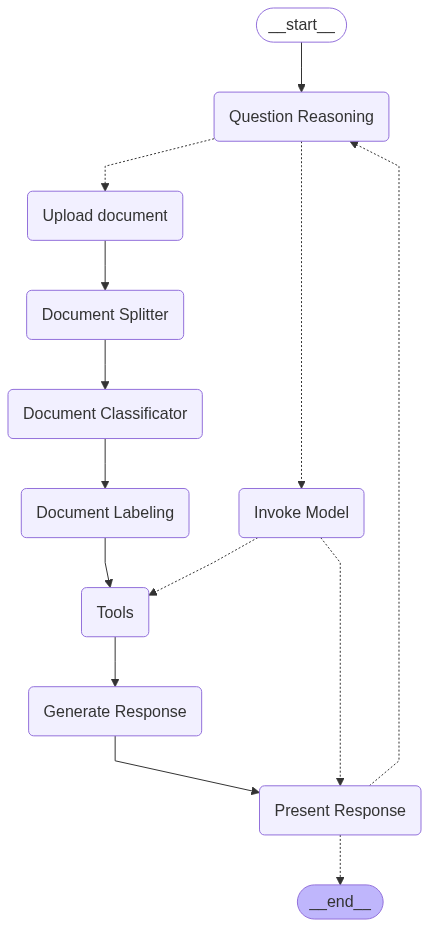

In [22]:
from langgraph.graph import StateGraph
from langgraph.graph.state import START, END
from IPython.display import Image, display

graph_builder = StateGraph(MsgState)

# Nodes
graph_builder.add_node("Question Reasoning", question_reasoning)
graph_builder.add_node("Invoke Model", invoke_model)
graph_builder.add_node("Tools", tools)
graph_builder.add_node("Generate Response", generate_response)
graph_builder.add_node("Present Response", present_response)

graph_builder.add_node("Upload document", upload_documents)
graph_builder.add_node("Document Splitter", split_documents_per_context)
graph_builder.add_node("Document Classificator", document_classificator)
graph_builder.add_node("Document Labeling", document_labeling)


graph_builder.add_edge(START, "Question Reasoning")
graph_builder.add_conditional_edges("Question Reasoning",
                                    should_review_document,
                                    ["Invoke Model", "Upload document"])
graph_builder.add_conditional_edges(
    "Invoke Model",
    should_collect_more_info,
    ["Tools", "Present Response"]
)
graph_builder.add_edge("Upload document", "Document Splitter")
graph_builder.add_edge("Document Splitter", "Document Classificator")
graph_builder.add_edge("Document Classificator", "Document Labeling")
graph_builder.add_edge("Document Labeling", "Tools")

graph_builder.add_edge("Tools","Generate Response")
graph_builder.add_edge("Generate Response", "Present Response")
graph_builder.add_conditional_edges("Present Response",
                                   should_continue,
                                    ["Question Reasoning", END])
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Communication with Graph

In [ ]:
q1 = "HI" #Initial question
end_state = graph.invoke({
    "messages":[HumanMessage(content = q1)],
    "response_src":""
})

# I tried with 2 diffrent question, first question is document path, where agent analyze document, after that I ask him simply question from document
#1.  /content/drive/MyDrive/ESN_721526_Engine_Minipack.pdf
#2.  What is Time Since New Of ESN 721526

--- Activated 'Question Reasoning' node ---
RAW DECISION FROM LLM: ["general"]
QUERY TYPE: general
Data path: None
--- Activated 'should_review_document' node ---
NEXT NODE: Invoke Model
--- Activated 'Invoke Model' node ---
Function should_collect_more_info returns: Present Response
RESPONSE:
I'm happy to help you with any questions or tasks you have. What would you like to do first?


Please let me know if you have any futher questions
/content/drive/MyDrive/ESN_721526_Engine_Minipack.pdf
--- Activated 'should_continue' node ---
--- Activated 'Question Reasoning' node ---
RAW DECISION FROM LLM: ["document", "/content/drive/MyDrive/ESN_721526_Engine_Minipack.pdf"]
QUERY TYPE: document
Data path: /content/drive/MyDrive/ESN_721526_Engine_Minipack.pdf
--- Activated 'should_review_document' node ---
NEXT NODE: Upload document
--- Activated 'Upload Document' node ---
Processing file '/content/drive/MyDrive/ESN_721526_Engine_Minipack.pdf'
--- Activated 'split_documents_per_context' node ---

# Show data from database

Function which present last 5 documents from DB

In [ ]:
from langchain_chroma import Chroma

# open vDb
persist_directory = 'tech_doc_on_db'
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embadings)

# find documnets
all_docs = vectordb._collection.get(include=["documents"])
documents = all_docs['documents']

#show last 5
for i, doc in enumerate(documents[:-5]):
    print(f"Dokument {i}:\n{doc}\n{'-'*50}")

# Delete data from database

After processing, the database needs to be cleared to make reasoning easier for the model. This functionality could also be added to the agent as a new node, where the database would be deleted after completing the processing at that node.

In [ ]:
from langchain_chroma import Chroma

def clear_vector_db_data(persist_directory='tech_doc_on_db'):
    vectordb = Chroma(
        persist_directory=persist_directory,
        embedding_function=embadings
    )
    # Briše celu kolekciju iz baze
    vectordb._client.delete_collection(name=vectordb._collection.name)
    print("Deleted data from database")

clear_vector_db_data()

Function for mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')